## Imports and figure constants

In [49]:
import pandas as pd
import numpy as np
from itertools import chain
import glob
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.colors as mcolors
from matplotlib.colors import rgb2hex
from PIL import ImageColor
import geopandas as gpd
import datetime as dt
import matplotlib
import matplotlib.patches as mpatches
from matplotlib import font_manager
from matplotlib.dates import date2num
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import Normalize
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import ListedColormap
import matplotlib.dates as md
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from seaborn.matrix import _HeatMapper
from six import string_types
from seaborn.utils import despine, axis_ticklabels_overlap, relative_luminance, to_utf8
import time
import string
import warnings
warnings.filterwarnings('ignore')

In [50]:
# Define gradient color
gradient = ['#E7EAEE','#96B7D6', '#001842']
cm = LinearSegmentedColormap.from_list(
        "Custom", gradient, N=100)

In [51]:
# Define chart color palette
chart = ['#2C2B2B','#565E69','#CACED3','#E7EAEE']

In [52]:
colors = ['#1A5784', '#38828C', '#84B5B2', '#60904F', '#ACC253', '#E7C960', '#E49243', '#D75F58', '#A04275', '#633D71', '#8c564b', '#c7c7c7']

In [53]:
# Define constants
figure_size = (20,6)

# Set background
sns.set_context('talk') #change the size from small to medium
sns.set_style('white') #change bg to white

# Add every font at the specified location
font_dir = ['/Users/haileyrobertson/Library/Fonts']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)
    
# Set font family globally
plt.rcParams['font.family'] = 'Open Sans'
plt.rcParams['font.weight'] = 'bold'

# Set margins
plt.rcParams['axes.xmargin'] = 0.9

# Define list of date formats
zfmts = ['', '%Y','%b\n%Y', '%b', '%b-%d', '%H:%M', '%H:%M']

# Format axes 
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.titlepad'] = 30

# Format ticks
plt.rcParams["xtick.direction"] = "out"
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.color'] = chart[2]
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['xtick.labelcolor'] = chart[1]
plt.rcParams['xtick.labelsize'] = 14

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.pad"] = -35
plt.rcParams["ytick.minor.pad"] = -35
plt.rcParams["ytick.major.size"] = 10
plt.rcParams["ytick.minor.size"] = 10
plt.rcParams["ytick.color"] = chart[2]
plt.rcParams["ytick.major.width"] = 1
plt.rcParams["ytick.minor.width"] = 1
plt.rcParams["ytick.labelcolor"] = chart[1]
plt.rcParams["ytick.labelsize"] = 14


# Adjust fontdict for title
titlefont = {'family': 'Open Sans',
             'color':  chart[0], 
             'weight': 400,
             'size': 20}

# Set grid style
plt.rcParams['grid.color'] = chart[2]
plt.rcParams['grid.linestyle'] = 'dashed'
plt.rcParams['grid.linewidth']=0.7

# Set legend style
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.handleheight'] = 1.125



# Set axis labels
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.labelcolor'] = chart[1]

In [54]:

class _ScatterMapper(_HeatMapper):
    """
    Draw a scattermap plot, similar to heatmap plot, but use scatter dots instead of heatmap
    """

    def __init__(self, data,
                 marker, marker_size,
                 vmin, vmax, cmap, center, robust, cbar, cbar_kws,
                 xticklabels=True, yticklabels=True, mask=None):

        super(_ScatterMapper, self).__init__(
            data, vmin, vmax, cmap, center, robust, cbar=cbar, cbar_kws=cbar_kws,
            xticklabels=xticklabels, yticklabels=yticklabels, mask=mask,
            # Don't support annotation
            annot=False, fmt=None, annot_kws=None,
        )

        self.marker = marker

        if isinstance(marker_size, float) or isinstance(marker_size, int):
            self.marker_size = marker_size
        elif isinstance(marker_size, pd.DataFrame):
            self.marker_size = marker_size.loc[self.data.index, self.data.columns].values
        else:
            self.marker_size = marker_size
        
    def plot(self, ax, cax, kws):
        """Draw the scattermap on the provided Axes."""
        # Remove all the Axes spines
        despine(ax=ax, left=True, bottom=True)

        # Draw the heatmap
        data = self.plot_data

        range_y = np.arange(data.shape[0], dtype=int) + 0.5
        range_x = np.arange(data.shape[1], dtype=int) + 0.5
        x, y = np.meshgrid(range_x, range_y)

        hmap = ax.scatter(x, y,
                          c=data,
                          marker=self.marker,
                          cmap=self.cmap,
                          vmin=self.vmin, vmax=self.vmax,
                          s=self.marker_size, **kws)

        # Set the axis limits
        ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))

        # Possibly add a colorbar
        if self.cbar:
            cb = ax.figure.colorbar(hmap, cax, ax, **self.cbar_kws)
            cb.outline.set_linewidth(0)
            # If rasterized is passed to pcolormesh, also rasterize the
            # colorbar to avoid white lines on the PDF rendering
            if kws.get('rasterized', False):
                cb.solids.set_rasterized(True)

        # Add row and column labels
        if isinstance(self.xticks, string_types) and self.xticks == "auto":
            xticks, xticklabels = self._auto_ticks(ax, self.xticklabels, 0)
        else:
            xticks, xticklabels = self.xticks, self.xticklabels

        if isinstance(self.yticks, string_types) and self.yticks == "auto":
            yticks, yticklabels = self._auto_ticks(ax, self.yticklabels, 1)
        else:
            yticks, yticklabels = self.yticks, self.yticklabels

        ax.set(xticks=xticks, yticks=yticks)
        xtl = ax.set_xticklabels(xticklabels)
        ytl = ax.set_yticklabels(yticklabels, rotation="vertical")

        # Possibly rotate them if they overlap
        ax.figure.draw(ax.figure.canvas.get_renderer())
        if axis_ticklabels_overlap(xtl):
            plt.setp(xtl, rotation="vertical")
        if axis_ticklabels_overlap(ytl):
            plt.setp(ytl, rotation="horizontal")

        # Add the axis labels
        ax.set(xlabel=self.xlabel, ylabel=self.ylabel)

        # Annotate the cells with the formatted values
        if self.annot:
            self._annotate_heatmap(ax, hmap)

        # Invert the y axis to show the plot in matrix form
        ax.invert_yaxis()

def scattermap(data,
               marker='o',
               marker_size=100,
               vmin=None, vmax=None, cmap=None, center=None, robust=False,
               linewidths=0, linecolor="white",
               cbar=True, cbar_kws=None, cbar_ax=None,
               square=False, xticklabels="auto", yticklabels="auto",
               mask=None, ax=None, **kwargs):
    """Plot rectangular data as a color-encoded matrix.
    This function is similar to `sns.heatmap`, as it is an Axes-level function that will draw the
    heatmap into the currently-active Axes if none is provided to the ``ax`` argument.
    The main difference is that instead of drawing an actual heatmap with filled squares,
    this function will use the `plt.scatter` behind the scenes to draw a scatterplot-heatmap.
    The default is set to plot a grid of circles, however this can be changed via `marker`
    parameter.
    Parameters
    ----------
    data : rectangular dataset
        2D dataset that can be coerced into an ndarray. If a Pandas DataFrame
        is provided, the index/column information will be used to label the
        columns and rows.
    marker: string, optional
        Marker to use: any marker that `pyplot.scatter` supports. Defaults to circle.
    marker_size: int or rectangular dataset
        Either an integer to set the marker size of all data points to,
        or a 2D dataset (like in `data`) that sets individual point sizes.
        Defaults to 100.
    vmin, vmax : floats, optional
        Values to anchor the colormap, otherwise they are inferred from the
        data and other keyword arguments.
    cmap : matplotlib colormap name or object, or list of colors, optional
        The mapping from data values to color space. If not provided, the
        default will depend on whether ``center`` is set.
    center : float, optional
        The value at which to center the colormap when plotting divergant data.
        Using this parameter will change the default ``cmap`` if none is
        specified.
    robust : bool, optional
        If True and ``vmin`` or ``vmax`` are absent, the colormap range is
        computed with robust quantiles instead of the extreme values.
    linewidths : float, optional
        Width of the border lines that will surround the markers
    linecolor : color, optional
        Color of the border lines to the markers
    cbar : boolean, optional
        Whether to draw a colorbar.
    cbar_kws : dict of key, value mappings, optional
        Keyword arguments for `fig.colorbar`.
    cbar_ax : matplotlib Axes, optional
        Axes in which to draw the colorbar, otherwise take space from the
        main Axes.
    square : boolean, optional
        If True, set the Axes aspect to "equal" so each cell will be
        square-shaped.
    xticklabels, yticklabels : "auto", bool, list-like, or int, optional
        If True, plot the column names of the dataframe. If False, don't plot
        the column names. If list-like, plot these alternate labels as the
        xticklabels. If an integer, use the column names but plot only every
        n label. If "auto", try to densely plot non-overlapping labels.
    mask : boolean array or DataFrame, optional
        If passed, data will not be shown in cells where ``mask`` is True.
        Cells with missing values are automatically masked.
    ax : matplotlib Axes, optional
        Axes in which to draw the plot, otherwise use the currently-active
        Axes.
    kwargs : other keyword arguments
        All other keyword arguments are passed to ``ax.pcolormesh``.
    Returns
    -------
    ax : matplotlib Axes
        Axes object with the heatmap.
    See also
    --------
    clustermap : Plot a matrix using hierachical clustering to arrange the
                 rows and columns.
    Examples
    --------
    Plot a scattermap for a numpy array:
    .. plot::
        :context: close-figs
        >>> import numpy as np; np.random.seed(0)
        >>> import seaborn as sns; sns.set()
        >>> uniform_data = np.random.rand(10, 12)
        >>> ax = scattermap(uniform_data)
    Draw on white axes
    .. plot::
        :context: close-figs
        >>> uniform_data = np.random.rand(10, 12)
        >>> with sns.axes_style("white"):
        ...     ax = scattermap(uniform_data)
    Change the limits of the scattermap:
    .. plot::
        :context: close-figs
        >>> ax = scattermap(uniform_data, vmin=0, vmax=1)
    Plot a scattermap for data centered on 0 with a diverging colormap:
    .. plot::
        :context: close-figs
        >>> normal_data = np.random.randn(10, 12)
        >>> ax = scattermap(normal_data, center=0)
    Plot a dataframe with meaningful row and column labels:
    .. plot::
        :context: close-figs
        >>> flights = sns.load_dataset("flights")
        >>> flights = flights.pivot("month", "year", "passengers")
        >>> ax = scattermap(flights)
    Add border lines around each glyph:
    .. plot::
        :context: close-figs
        >>> ax = scattermap(flights, linewidths=1, linecolor='black')
    Use a different colormap:
    .. plot::
        :context: close-figs
        >>> ax = scattermap(flights, cmap="YlGnBu")
    Center the colormap at a specific value:
    .. plot::
        :context: close-figs
        >>> ax = scattermap(flights, center=flights.loc["January", 1955])
    Plot every other column label and don't plot row labels:
    .. plot::
        :context: close-figs
        >>> data = np.random.randn(50, 20)
        >>> ax = scattermap(data, xticklabels=2, yticklabels=False)
    Don't draw a colorbar:
    .. plot::
        :context: close-figs
        >>> ax = scattermap(flights, cbar=False)
    Use different axes for the colorbar:
    .. plot::
        :context: close-figs
        >>> grid_kws = {"height_ratios": (.9, .05), "hspace": .3}
        >>> f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws)
        >>> ax = scattermap(flights, ax=ax,
        ...                  cbar_ax=cbar_ax,
        ...                  cbar_kws={"orientation": "horizontal"})
    Use a mask to plot only part of a matrix
    .. plot::
        :context: close-figs
        >>> corr = np.corrcoef(np.random.randn(10, 200))
        >>> mask = np.zeros_like(corr)
        >>> mask[np.triu_indices_from(mask)] = True
        >>> with sns.axes_style("white"):
        ...     ax = scattermap(corr, mask=mask, vmax=.3, square=True)
     Change glyph, plot stars instead of circles
    .. plot::
        :context: close-figs
        >>> ax = scattermap(corr, vmax=.3, square=True, marker='*')
    Plot multiple markers on the same plot
    >>> corr = np.corrcoef(np.random.randn(10, 200))
    >>> mask = np.zeros_like(corr)
    >>> mask[np.triu_indices_from(mask)] = True
    >>> with sns.axes_style("white"):
    ...     ax = scattermap(corr, mask=mask, vmax=.3, square=True)
    ...     ax = scattermap(corr, mask=mask.T, vmax=.3, square=True, ax=ax, marker='*', cbar=False)
    Specify size for points
    .. plot::
        :context: close-figs
    >>> with sns.axes_style("white"):
    ...     ax = scattermap(corr, vmax=.3, square=True, marker_size=np.abs(corr)*300)
    """
    # Initialize the plotter object
    plotter = _ScatterMapper(data,
                             marker, marker_size,
                             vmin, vmax, cmap, center, robust,
                             cbar, cbar_kws, xticklabels,
                             yticklabels, mask)

    # Add the pcolormesh kwargs here
    kwargs["linewidths"] = linewidths
    kwargs["edgecolor"] = linecolor

    # Draw the plot and return the Axes
    if ax is None:
        ax = plt.gca()
    if square:
        ax.set_aspect("equal")
    plotter.plot(ax, cbar_ax, kwargs)
    return ax


In [33]:
# Function to remove the first and last characters from a string
def remove_chars(s):
    return s[1:-1]

In [56]:
# Function to process dataframes
def process_dataframe(df):
    df["yearMonth"] = df["yearMonth"].apply(remove_chars)
    df["species"] = df["species"].apply(remove_chars)
    df['country'] = df['country'].apply(remove_chars)
    df['class'] = df['class'].apply(remove_chars)
    df['yearMonth'] = pd.to_datetime(df['yearMonth'], format="mixed")
    return df

## Figure 4

In [35]:
# Load the data
animal = pd.read_csv("data/h5n1_cases_country_species_class_month.csv")

# Process the dataframes
animal = process_dataframe(animal)

# Define the date range
start_date = '2020-01-01'
end_date = '2023-07-01'

# Filter the dataframe
animal = animal[(animal['yearMonth'] >= start_date) & (animal['yearMonth'] <= end_date)]

# Load the country match data
country_match = pd.read_csv("data/country_match.csv")
country_match["iso2"] = country_match["iso2"].apply(remove_chars)
country_match["iso3"] = country_match["iso3"].apply(remove_chars)

animal = pd.merge(animal, country_match, left_on="country",right_on="iso2",how="outer")

In [36]:
mammals = animal.loc[animal['class']=="Mammalia"]

### Fig 4a

In [37]:
agg_mammals = mammals.groupby(['iso2', 'iso3','name']).agg({'monthlyCases': 'sum'}).reset_index()
agg_mammals["animalCases"] = agg_mammals["monthlyCases"].fillna(0)

In [38]:
# World geometry shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.rename(columns={"iso_a3":"iso3"})
cols = ['name','iso3','geometry']
world = world[cols]
world = world.sort_values(by="iso3")

# Fix known issues in geopandas
world.loc[world['name'] == 'France', 'iso3'] = 'FRA'
world.loc[world['name'] == 'Norway', 'iso3'] = 'NOR'
world.loc[world['name'] == 'Somaliland', 'iso3'] = 'SOM'
world.loc[world['name'] == 'Kosovo', 'iso3'] = 'RKS'

# Merge geometry, exclude Antarctica for aesthetics (No cases)
mammals_geo = pd.merge(world,agg_mammals,on='iso3',how='outer')
mammals_geo = mammals_geo[(mammals_geo.name_x != "Antarctica")]

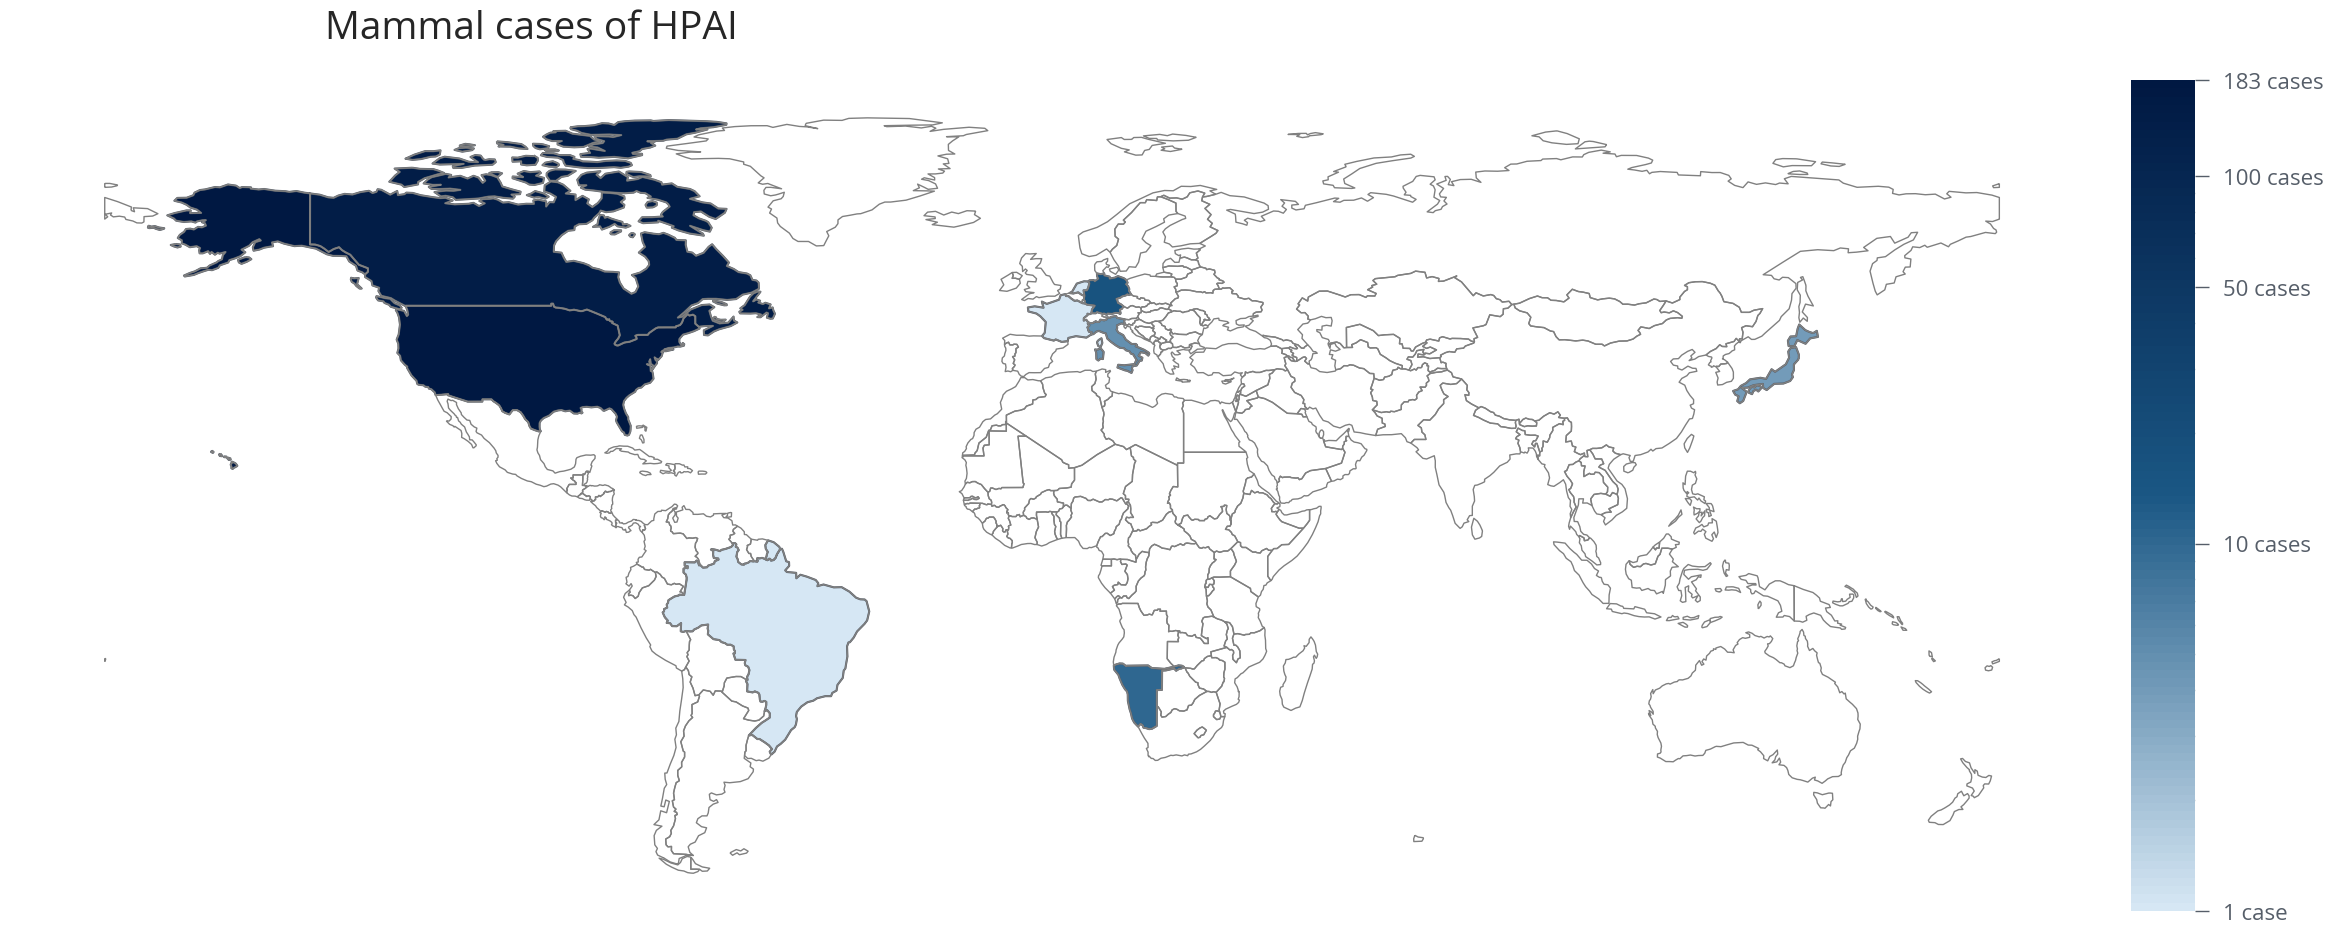

In [39]:
# Ensure the correct geometry column is set
mammals_geo = mammals_geo.set_geometry('geometry') 

# Define your custom gradient color map
gradient = ['#D6E7F4','#1A5784', '#001842']
cm = LinearSegmentedColormap.from_list("Custom", gradient, N=100)

# Create a new figure and axes
fig, ax = plt.subplots(figsize=(24, 18))

# Define the minimum and maximum values
vmin = 1  # Setting to 1 to avoid log(0)
vmax = 183

# Use LogNorm for logarithmic color scale
norm = mcolors.LogNorm(vmin=vmin, vmax=vmax)

# Plot the map with white borders
mammals_geo.boundary.plot(ax=ax, linewidth=1, color='grey')
mammals_geo.plot(column='animalCases', cmap=cm, norm=norm, legend=False, ax=ax, edgecolor=chart[1])

# Adjust margins and set title
ax.margins(x=0.05)
ttl = ax.set_title('Mammal cases of HPAI', fontsize=28)
ttl.set_position([0.25, 1.05])

# Set the background color of the map
ax.set(facecolor='white')

# Turn axis off
ax.axis('off')

# Create a colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05)
sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
sm._A = []

# Define the ticks for the logarithmic scale
ticks = [1, 10, 50, 100, 183]
cbar = plt.colorbar(sm, cax=cax, drawedges=False, ticks=ticks)
cbar.ax.set_yticklabels([f"{int(tick)} case" if tick == 1 else f"{int(tick)} cases" for tick in ticks])
cbar.ax.yaxis.set_tick_params(direction='out', length=10, width=1, pad=10, colors=chart[1], labelsize=16)
cbar.outline.set_visible(False)

# # Display the map
plt.tight_layout()
plt.show()

# # Save the figure
# plt.savefig('figures/h5n1_mammal_outbreak_all.png', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait', bbox_inches='tight')


### Figure 4b

In [44]:
# Group by species and calculate the sum of monthlyCases for each species
mammals['yearMonth'] = pd.to_datetime(mammals['yearMonth'], format="%Y-%m")

mon_mammals = mammals.groupby('species')['monthlyCases'].sum().reset_index()

# Sort the species by their totalCases in descending order
sorted_df = mon_mammals.sort_values(by='monthlyCases', ascending=False)

# Retrieve the top 10 species with the highest total cases
top_10_species = sorted_df.head(10)

# Convert the top 10 species to a list and sort alphabetically
species_list = sorted(top_10_species['species'].tolist())

# Filter the DataFrame to only include rows with the specified species names
filtered_df = mammals[mammals['species'].isin(species_list)]

In [45]:
# Pivot the DataFrame with species as columns
pivot_df = filtered_df.pivot_table(index='yearMonth', columns='species', values='monthlyCases', aggfunc = 'sum',fill_value=0)

# Flatten the DataFrame
pivot_df.reset_index(inplace=True)

# Set 'yearMonth' as the index again
pivot_df.set_index('yearMonth', inplace=True)

# Resample the DataFrame and forward fill missing months
pivot_df = pivot_df.asfreq('MS',fill_value=0).reset_index()

pivot_df['total'] = pivot_df[species_list].sum(axis=1)

pivot_df.head()

species,yearMonth,Bos taurus,Canis lupus familiaris,Didelphis virginiana,Felis catus,Lynx rufus,Mephitis mephitis,Pekania pennanti,Phoca vitulina,Puma,Vulpes vulpes,total
0,2022-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,2022-04-01,0.0,0.0,0.0,0.0,1.0,5.0,1.0,0.0,1.0,39.0,47.0
2,2022-05-01,0.0,0.0,2.0,0.0,1.0,28.0,0.0,0.0,0.0,50.0,81.0
3,2022-06-01,0.0,0.0,0.0,0.0,0.0,3.0,0.0,17.0,0.0,7.0,27.0
4,2022-07-01,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,11.0


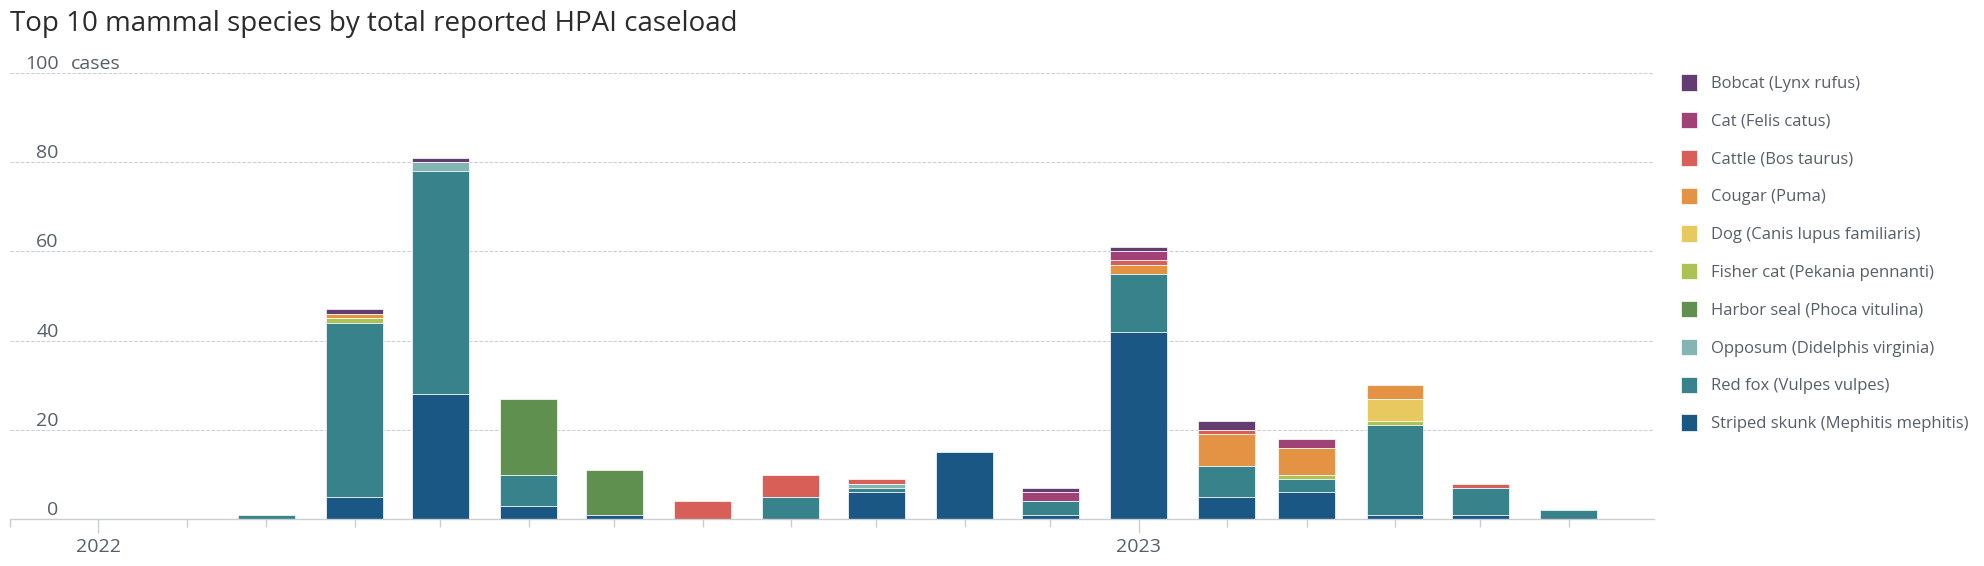

In [46]:
# Format figure
fig, ax = plt.subplots(figsize=(figure_size))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')

# Define variables
x=pivot_df['yearMonth']
y1=pivot_df['Lynx rufus']
y2=pivot_df['Felis catus']
y3=pivot_df['Bos taurus']
y4=pivot_df['Puma']
y5=pivot_df['Canis lupus familiaris']
y6=pivot_df['Pekania pennanti']
y7=pivot_df['Phoca vitulina']
y8= pivot_df['Didelphis virginiana']
y9 = pivot_df['Vulpes vulpes']
y10 =pivot_df['Mephitis mephitis']

# Plot bars
# The thing that gets plotted last in this list gets plotted on the bottom

plt.bar(x, y1, bottom=y2+y3+y4+y5+y6+y7+y8+y9+y10, linewidth=0.5, width=20, align="center", color=colors[9], label='Bobcat (Lynx rufus)') 
plt.bar(x, y2, bottom=y3+y4+y5+y6+y7+y8+y9+y10, linewidth=0.5, width=20, align="center", color=colors[8], label='Cat (Felis catus)')
plt.bar(x, y3, bottom=y4+y5+y6+y7+y8+y9+y10, linewidth=0.5,width=20, align="center", color=colors[7], label='Cattle (Bos taurus)')
plt.bar(x, y4, bottom=y5+y6+y7+y8+y9+y10, linewidth=0.5,width=20, align="center", color=colors[6], label='Cougar (Puma)')
plt.bar(x, y5, bottom=y6+y7+y8+y9+y10, linewidth=0.5, width=20, align="center", color=colors[5], label='Dog (Canis lupus familiaris)')
plt.bar(x, y6, bottom=y7+y8+y9+y10, linewidth=0.5, width=20, align="center", color=colors[4], label='Fisher cat (Pekania pennanti)')
plt.bar(x, y7, bottom=y8+y9+y10, linewidth=0.5,width=20, align="center", color=colors[3], label='Harbor seal (Phoca vitulina)')
plt.bar(x, y8, bottom=y9+y10, linewidth=0.5,width=20, align="center", color=colors[2], label='Opposum (Didelphis virginia)')
plt.bar(x, y9, bottom=y10, linewidth=0.5, width=20, align="center", color=colors[1], label='Red fox (Vulpes vulpes)')
plt.bar(x, y10, bottom=0, linewidth=0.5, width=20, align="center", color=colors[0], label='Striped skunk (Mephitis mephitis)')


ax.xaxis_date()

# Define x-axis range
left = dt.date(2021, 12, 1)
right = dt.date(2023, 7, 1)

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0,100)

# Set major and minor date tick locators
maj_loc = mdates.YearLocator()
ax.xaxis.set_major_locator(maj_loc)
min_loc = mdates.MonthLocator()
ax.xaxis.set_minor_locator(min_loc)

# Set major date tick formatter
maj_fmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(maj_fmt)

# Hide minor tick labels
ax.xaxis.set_tick_params(which='minor', labelbottom=False)

# Set title
title = "Top 10 mammal species by total reported HPAI caseload"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Extend x-axis without showing labels
for label in ax.xaxis.get_ticklabels()[:1]:
    label.set_visible(False)
    
for x in ax.xaxis.get_major_ticks()[:1]:
    x.set_visible(False) 
    
for x in ax.xaxis.get_minor_ticks()[-1:]:
    x.set_visible(False)

# Format y-axis label
plt.ylabel("cases", rotation=0,loc='top',labelpad=-80,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")
    
# after plotting the data, format the labels
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.20,1.03),labelcolor=chart[1],labelspacing=1.2)


plt.tight_layout()
plt.show()
# plt.savefig('figures/hpai_mammal_10_2022.png', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait',bbox_inches='tight')

## Figure 5a

In [445]:
top = pd.read_csv('data/all_influenza_host_species_class_country_month.csv')
top = process_dataframe(top)
top = top.loc[top['class']=="Mammalia"]

country_match = pd.read_csv("data/country_match.csv")
country_match['iso2'] = country_match['iso2'].apply(remove_chars)


top = pd.merge(top, country_match, left_on = "country", right_on = "iso2")
top = top.drop(columns=['country'])


top['iso3'] = top['iso3'].apply(remove_chars)
top['name'] = top['name'].apply(remove_chars)

In [446]:
grouped_df = top.pivot_table(index=['iso2'], columns=['species'], values='monthlyCases',sort=True)

In [447]:
grouped = pd.read_csv('data/countries_by_human_cases.csv')

grouped["country"] = grouped["country"].astype('str').apply(remove_chars)

In [448]:
hm = pd.merge(grouped_df, grouped, left_on = 'iso2',right_on='country')
hm = hm.rename(columns={'totalCases':'Homo sapiens real'})

In [449]:
hm = hm.drop(columns=['Homo sapiens'])
hm = hm.rename(columns={'Homo sapiens real':'Homo sapiens'})

In [450]:
# Set 'country' as the index
hm.set_index('country', inplace=True)

# Sort countries by total cases in descending order and get the top 20
top_countries = hm.sort_values(by='Homo sapiens', ascending=False).head(20)

top_countries = top_countries.index.tolist()
print(top_countries)

['CN', 'CA', 'FR', 'US', 'NO', 'MX', 'ES', 'SE', 'JP', 'CH', 'DK', 'AR', 'AU', 'IT', 'QA', 'CL', 'NL', 'PT', 'AT', 'IN']


In [452]:
top20 = hm.loc[top_countries]

top20 = top20.fillna(0)
top20 = top20.astype('int')

top20.replace(0,np.nan, inplace=True)

top20= top20.drop(columns=['Canis latrans','Martes martes','Nasua nasua'])

In [453]:
top20 = top20.transpose()
top20.head()

country,CN,CA,FR,US,NO,MX,ES,SE,JP,CH,DK,AR,AU,IT,QA,CL,NL,PT,AT,IN
Bos taurus,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
Canis lupus familiaris,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN
Didelphis virginiana,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Equidae,5925.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,454.0,NaN,NaN,NaN,727.0,11.0,NaN,56.0,NaN,NaN,NaN,2440.0
Felis catus,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [454]:
top20 = top20.rename(columns={
    'CN': 'China',
    'CA': 'Canada',
    'FR': 'France',
    'US': 'United States',
    'NO': 'Norway',
    'MX': 'Mexico',
    'ES': 'Spain',
    'SE': 'Sweden',
    'JP': 'Japan',
    'CH': 'Switzerland',
    'DK': 'Denmark',
    'AR': 'Argentina',
    'AU': 'Australia',
    'IT': 'Italy',
    'QA': 'Qatar',
    'CL': 'Chile',
    'NL': 'Netherlands',
    'PT': 'Portugal',
    'AT': 'Austria',
    'IN': 'India'
}
)

In [455]:
# Sum across the columns to get total cases per species
top20['Total Cases'] = top20.sum(axis=1)

# Sort by total cases in descending order
top20 = top20.sort_values(by='Total Cases', ascending=False)

# Remove the 'Total Cases' column if you don't need it anymore
top20 = top20.drop(columns='Total Cases')

In [456]:
# Example mapping dictionary (replace with your actual mapping)
species_mapping = {
    'Homo sapiens': 'Human (Homo sapiens)',
    'Neogale vison': 'American mink (Neogale vison)',
    'Equidae': 'Horse (Equidae)',
    'Sus scrofa': 'Wild boar (Sus scrofa)',
    'Vulpes vulpes': 'Red fox (Vulpes vulpes)',
    'Mephitis mephitis': 'Striped skunk (Mephitis mephitis)',
    'Phoca vitulina': 'Harbor seal (Phoca vitulina)',
    'Canis lupus familiaris': 'Domestic dog (Canis lupus familiaris)',
    'Puma': 'Cougar (Puma)',
    'Bos taurus': 'Cattle (Bos taurus)',
    'Felis catus': 'Domestic cat (Felis catus)',
    'Pekania pennanti': 'Fisher (Pekania pennanti)',
    'Ursus arctos': 'Brown bear (Ursus arctos)',
    'Didelphis virginiana': 'Virginia opossum (Didelphis virginiana)',
    'Panthera pardus orientalis': 'Amur leopard (Panthera pardus orientalis)',
    'Martes americana': 'American marten (Martes americana)',
    'Lynx rufus': 'Bobcat (Lynx rufus)',
    'Lontra canadensis': 'North American river otter (Lontra canadensis)',
    'Halichoerus grypus': 'Gray seal (Halichoerus grypus)',
    'Nyctereutes procyonoides': 'Raccoon dog (Nyctereutes procyonoides)'
}

# Apply the mapping to rename the index
top20.index = top20.index.map(species_mapping)


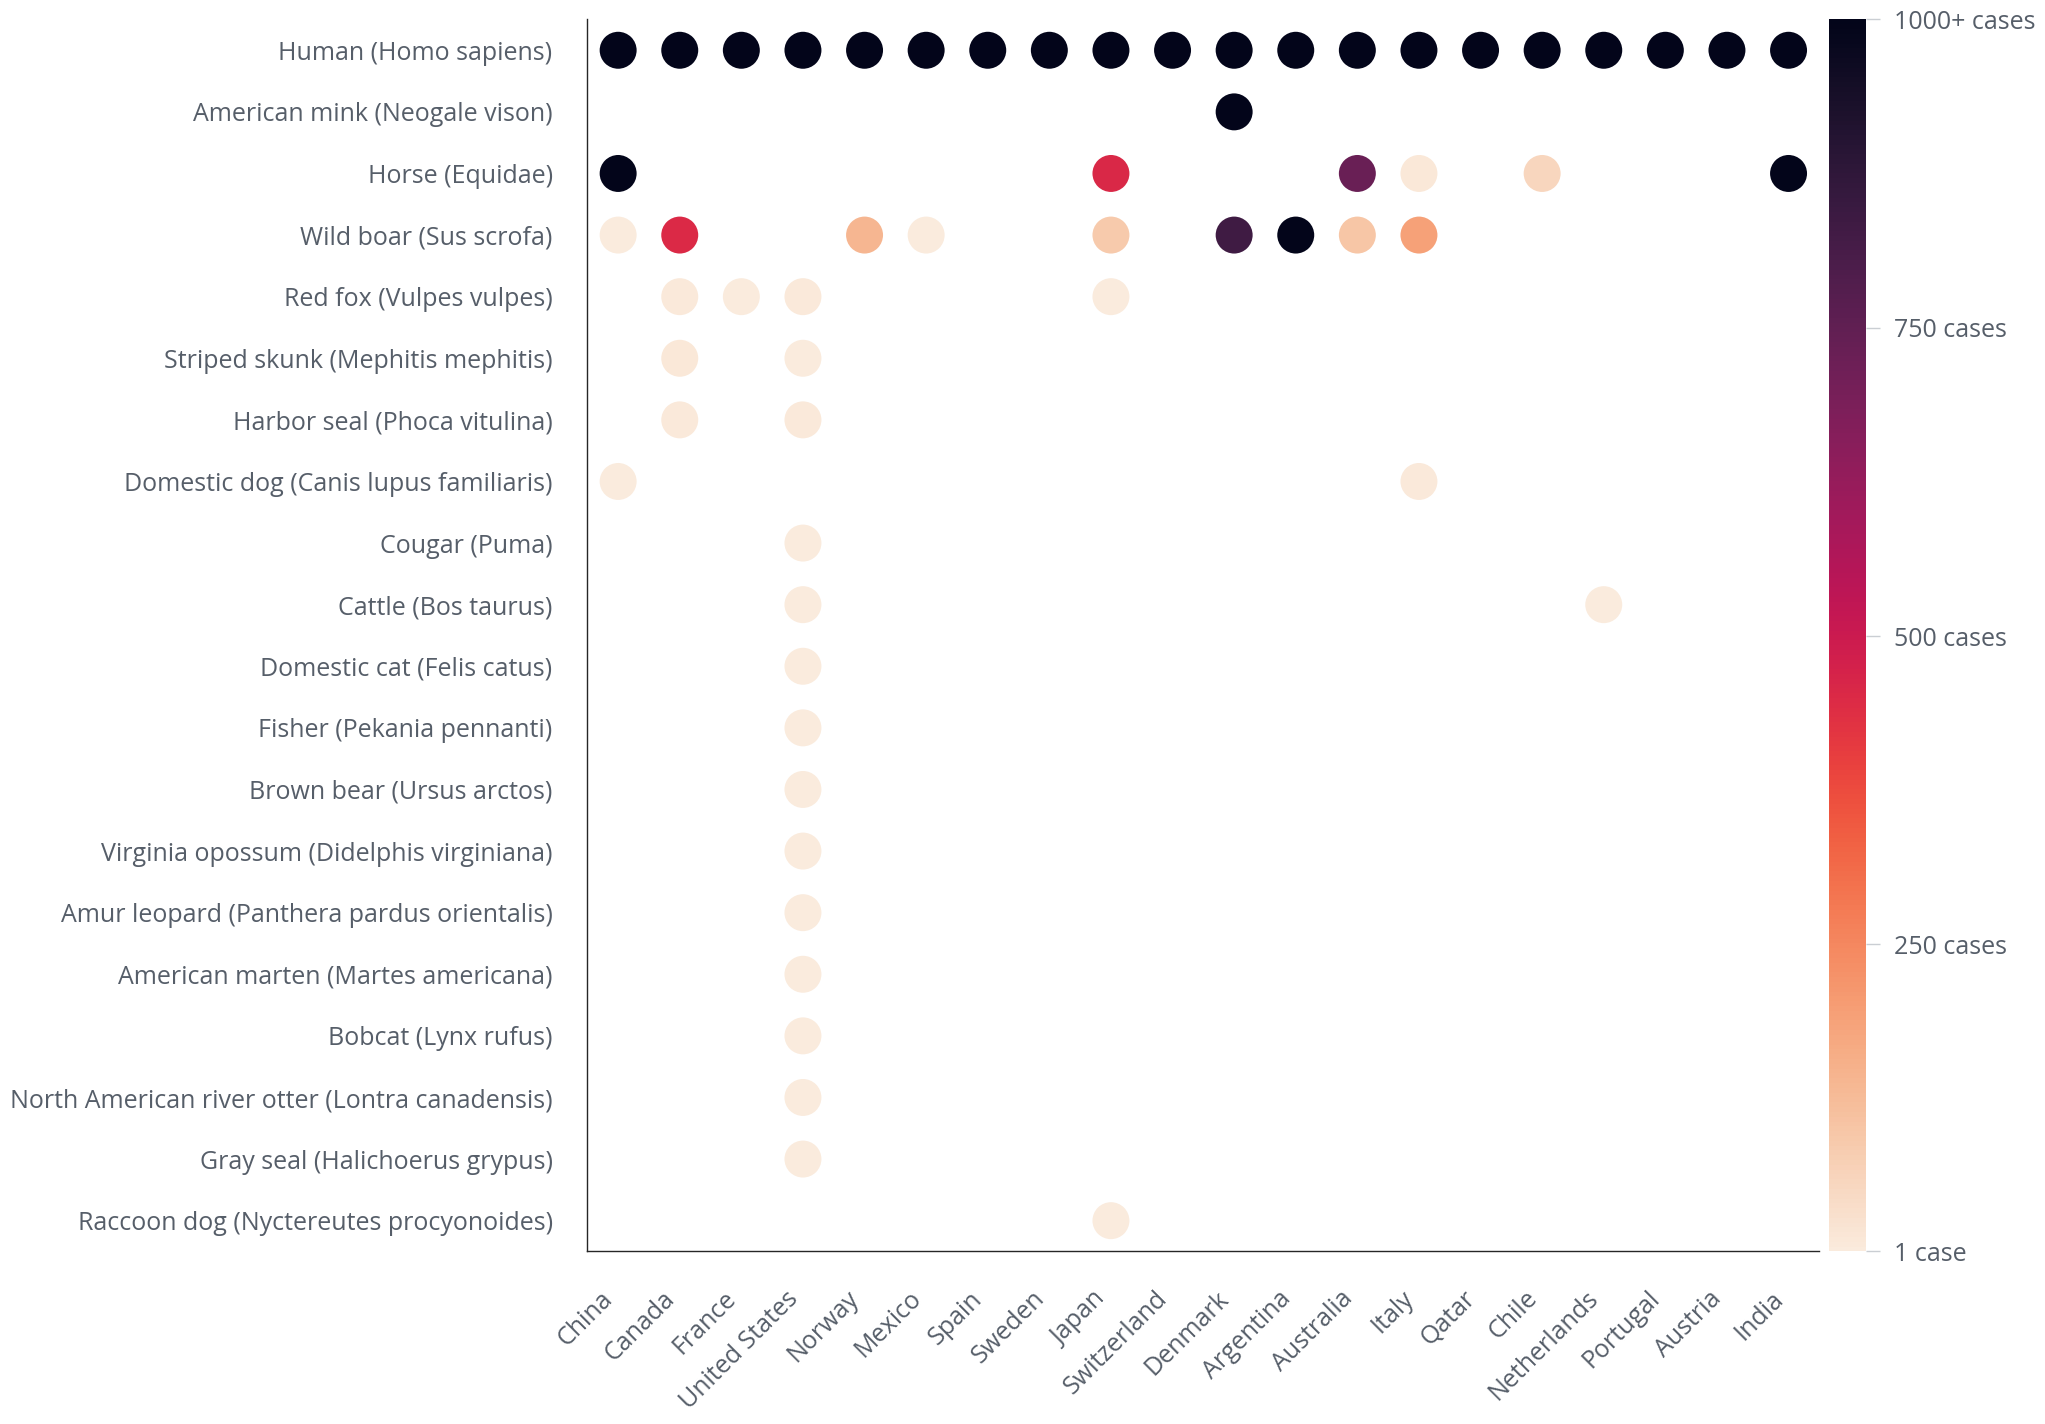

In [461]:
# Set up the heatmap figure
fig, ax = plt.subplots(figsize=(20, 16))

# Set the minimum and maximum values for the color scale
vmin = 1
vmax = 1000

# Create a log-normalized color scale
norm = mcolors.LogNorm(vmin, vmax)

# Create the scattermap
im = scattermap(data=top20, cbar=False, cmap="rocket_r", vmin=vmin, vmax=vmax, marker_size=1000, linewidths=5, ax=ax)

# Calculate ticks for color bar
ticks = np.linspace(vmin, vmax, num=5, dtype=int)

# Add a logarithmic color bar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)  # Adjust size and pad as needed
cbar = plt.colorbar(im.collections[0], cax=cax, orientation='vertical', ticks=ticks)

# Customize tick labels
tick_labels = [f"{tick} cases" for tick in ticks]
tick_labels[0] = f"{ticks[0]} case"
tick_labels[-1] = f"{ticks[-1]}+ cases"

cbar.ax.set_yticklabels(tick_labels)
cbar.ax.yaxis.set_tick_params(direction='out', length=10, width=1, pad=10, labelsize=18)
cbar.outline.set_visible(False)

# Set tick labels and axis labels
ax.set_xlabel('', labelpad=25)
ax.set_ylabel('', labelpad=25)
ax.set_title("", loc="left", size=24)

# Customize tick parameters and labels for both x and y axes
ax.tick_params(axis='x', pad=25, length=0, labelsize=10, width=100)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", size=18)

ax.tick_params(axis='y', pad=25, width=30, labelsize=10)
ax.tick_params(top=False, bottom=True, labeltop=False, labelbottom=True)
plt.setp(ax.get_yticklabels(), rotation=0, size=18)

# Customize spines
ax.spines.bottom.set_visible(True)
ax.spines.left.set_visible(True)

# Set aspect ratio
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

# # Save the figure if needed
# plt.savefig('figures/dot_hostpath_mammals300.png', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', bbox_inches='tight')
